In [1]:
from tvDatafeed import TvDatafeed,Interval
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
import os
import json
import numpy as np
import requests
from trade import cross_ema, ichimoku_cloud, macd, collect_mtfssl_pvtdiver
from sklearn import preprocessing
import datetime
# from talib.abstract import EMA, MACD

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
tv = TvDatafeed(username=None,password=None)

you are using nologin method, data you access may be limited


In [112]:
nifty_data=tv.get_hist('TENCENT80','SET',interval=Interval.in_daily,n_bars=10000)

In [3]:
with open(os.path.join(os.getcwd(),'config','list_stock','stock_config.json')) as f:
    json_stock = json.load(f)

In [4]:
def get_data(tv, exchange, name_stock, n_bars):
    return tv.get_hist(name_stock, exchange, interval=Interval.in_daily, n_bars=n_bars)

In [20]:
indicator_config = {
    "cross_ema":{
        "low_span": 90,
        "long_span": 95
    },
    "plot_config":{
        "plot": False,
        "n_bar": 60
    }
}
    
# หาวันที่ควรซื้อหุ้นนี้ล่าสุด
df = get_data(tv, "SET", "CPALL", 10000)
result, df = cross_ema(df,"CPALL",**indicator_config)
df = df.reset_index()
df = df.dropna()
df = df.reset_index()
df['bors'] = df['low_df'] - df['long_df']
index_value = df[df['bors'] < 0].iloc[-1:].index.values[0]
df_date_buy = df.iloc[[int(index_value)+1]]
df_date_buy['datetime']
# df['bors'] = df.apply(calc_sum)

# df[df['ema']==0].iloc[-1:]

test: 64.19213628562352


4571   2022-12-08 09:00:00
Name: datetime, dtype: datetime64[ns]

In [21]:
import datetime

In [22]:
df_date_buy['datetime'].values[0]

numpy.datetime64('2022-12-08T09:00:00.000000000')

In [23]:
# convert from numpy.datetime64 to datetime.datetime
unix_epoch = np.datetime64(0, 's')
one_second = np.timedelta64(1, 's')
seconds_since_epoch = (df_date_buy['datetime'].values[0] - unix_epoch) / one_second
d = datetime.datetime.utcfromtimestamp(seconds_since_epoch)
d

datetime.datetime(2022, 12, 8, 9, 0)

In [24]:
cc = datetime.datetime.today().date() - d.date()
print(cc.days)

43


In [8]:
from talib.abstract import EMA, MACD

In [9]:
def macd_test(df, namest):
    df['macd_line'], df["signal_line"], _ = MACD(df['close'])
    macd_line = list(df['macd_line'])
    signal_line = list(df["signal_line"])
        
    #     buy
    if macd_line[-1] > signal_line[-1]:
        return 2, df #False
    #     sell
    elif macd_line[-1] < signal_line[-1]:
        return -1, df #True
    return 0, df

In [19]:
v = {'a':12,'b':20,'c':2}
dict(sorted(v.items(), key=lambda item: item[1],reverse=True))


{'b': 20, 'a': 12, 'c': 2}

In [20]:
r= {}
r['a']=1
r['b']=12
r

{'a': 1, 'b': 12}

In [11]:
df = get_data(tv, "SET", "CPALL", 100)
df = df.reset_index()
df = df[df['close'] == min(list(df['close']))] 
df
# df = df.iloc[:,2:]

# c= macd_test(df=df, namest="CPALL")
# ichimoku_cloud(df = df, namest="CPALL")
# macd(df = df, namest="CPALL")
# low_df = EMA(df['close'], 90)
# print(low_df[-1])
# low_df
# long_df = EMA(df['close'], long_span)

,datetime,symbol,open,high,low,close,volume
32,2022-10-07 09:00:00,SET:CPALL,54.5,54.5,53.5,53.75,11873659.0


In [35]:
indicator_config = {
    "ema":[
        {
            "low_span": 90,
            "long_span": 95
        },
        {
            "low_span": 100,
            "long_span": 200
        }
    ]
}
for i in indicator_config['ema']:
    print(i)

{'low_span': 90, 'long_span': 95}
{'low_span': 100, 'long_span': 200}


In [15]:
list(df['macd_line'])[-1]

1.013803161925182

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

list_stock = list()
indicator_config = {
    "ema":[
        {
            "low_span": 90,
            "long_span": 95
        },
        {
            "low_span": 100,
            "long_span": 200
        }
    ]
}

config = {
    "find-min": True,
    "find-max": True
}

# loop key score
dict_stock_name_score = {}
dict_min_value_1 = {}
dict_min_value_2 = {}
dict_remaining_date = {}

for key_exc in json_stock['list_stock']:
    for namest in json_stock['list_stock'][key_exc]:
        dict_stock_name_score.update({namest:0})

print('dict_stock_name_score:',dict_stock_name_score)
# find current date
current_date = datetime.datetime.today().date()

for key_exc in json_stock['list_stock']:
    for namest in json_stock['list_stock'][key_exc]:
        data = get_data(tv, key_exc, namest, 3000)
        data = data.reset_index()
        
        score_ema = 0
        score_mtfssl_pvtdiver = 0
        for iconfig in indicator_config['ema']:
            result_ema = cross_ema(df = data, namest = namest, **iconfig)
            result_mtfssl_pvtdiver = collect_mtfssl_pvtdiver(data, iconfig['low_span'],iconfig['long_span'])
            score_ema += result_ema[0]
            score_mtfssl_pvtdiver += result_mtfssl_pvtdiver

        result_ichimoku = ichimoku_cloud(df = data, namest = namest)
        result_macd = macd(df = data, namest= namest)
        

        dict_stock_name_score[namest] = dict_stock_name_score[namest] + score_ema + result_ichimoku[0] + result_macd[0] + score_mtfssl_pvtdiver

        # find row with the least close value 
        # df = df[df['close'] == min(list(df['close']))] 

        # find date with the least value in data. do it every month
        list_time = [62, 93]
        for t in list_time:
            data_follow_time = get_data(tv, key_exc, namest, t)
            data_follow_time = data_follow_time.reset_index()

            # find min value in dataframe
            data_cal_number_days = data_follow_time[data_follow_time['close'] == min(list(data_follow_time['close']))]
            # convert timestamp to datetime.date
            if len(data_cal_number_days) > 1:
                data_cal_number_days = data_cal_number_days.iloc[-1,:]
                date_min_value = data_cal_number_days['datetime'].to_pydatetime().date()
            else:
                # convert numpy.datetime64 to datetime
                date_min_value = pd.to_datetime(data_cal_number_days['datetime'].values[0]).to_pydatetime().date()
            # date_min_value = data_cal_number_days['datetime'].to_pydatetime().date()
            remaining_date = current_date - date_min_value
            
            df_min_value = data_follow_time[data_follow_time['close'] == min(list(data_follow_time['close']))]
            df_current_value = data_follow_time.iloc[-2:-1,:]
            if t == 62:
                dict_min_value_1[namest] = df_current_value['close'].values[0] - min(list(data_follow_time['close']))
                dict_remaining_date[namest] = remaining_date.days
            else:
                dict_min_value_2[namest] = df_current_value['close'].values[0] - min(list(data_follow_time['close']))
                dict_remaining_date[namest] = remaining_date.days
    #     break
    # break

# sort data by current close value minus the smallest a value in the past
dict_min_value_1_sort = dict(sorted(dict_min_value_1.items(), key=lambda item: item[1], reverse=True))
dict_min_value_2_sort = dict(sorted(dict_min_value_2.items(), key=lambda item: item[1], reverse=True))
# sort data remaining date
dict_remaining_date_sort = dict(sorted(dict_remaining_date.items(), key=lambda item: item[1], reverse=True))

print('-'*100)
print('dict_min_value_1_sort:',dict_min_value_1_sort)
print('-'*100)

print('result step 1:',dict_stock_name_score)

# loop increase score
for dict_sort_value in [dict_min_value_1_sort, dict_min_value_2_sort, dict_remaining_date_sort]:
    # normalize score
    list_score = [i*100 for i in range(1,len(dict_sort_value)+1)]
    np_score = np.array(list_score)
    normalized_arr = preprocessing.normalize([np_score])


    dict_score = {} 
    for score,(k,v) in zip(normalized_arr.tolist()[0],dict_sort_value.items()):
        dict_score.update({k:score})

    for k,v in dict_score.items():
        dict_stock_name_score[k] = dict_stock_name_score[k] + dict_score[k]


dict_stock_name_score_sort = dict(sorted(dict_stock_name_score.items(), key=lambda item: item[1], reverse=True))
print('-'*100)
for k,v in dict_stock_name_score_sort.items():
    print(k,v)
print('-'*100)

# score date buy last day


# score distance between min close value and close value have to buy

# print('-'*100)
# print('result:',dict_stock_name_score)
# print('-'*100)
# print('dict_min_value_1:',dict_min_value_1)
# print('-'*100)
# print('dict_min_value_2:',dict_min_value_2)
# print('-'*100)
# print('dict_min_value_1_sort:',dict_min_value_1_sort)
# print('-'*100)
# print('dict_min_value_2_sort:',dict_min_value_2_sort)
# print('-'*100)



dict_stock_name_score: {'M': 0, 'CRC': 0, 'HMPRO': 0, 'TISCO': 0, 'CPALL': 0, 'KBANK': 0, 'DELTA': 0, 'AOT': 0, 'BANPU': 0, 'BDMS': 0, 'ADVANC': 0, 'PTTEP': 0, 'PTT': 0, 'COM7': 0, 'TOP': 0, 'SCB': 0, 'THG': 0, 'AAPL': 0}
----------------------------------------------------------------------------------------------------
dict_min_value_1_sort: {'DELTA': 304.0, 'ADVANC': 17.0, 'KBANK': 12.0, 'AAPL': 10.250000000000014, 'CPALL': 10.25, 'SCB': 8.0, 'TISCO': 7.75, 'TOP': 6.25, 'PTTEP': 6.0, 'THG': 4.75, 'CRC': 3.75, 'COM7': 3.25, 'PTT': 2.5, 'BDMS': 2.25, 'M': 2.0, 'AOT': 1.5, 'HMPRO': 0.8000000000000007, 'BANPU': 0.0}
----------------------------------------------------------------------------------------------------
result step 1: {'M': 3, 'CRC': 5, 'HMPRO': 5, 'TISCO': 8, 'CPALL': 5, 'KBANK': 7, 'DELTA': 5, 'AOT': 5, 'BANPU': 3, 'BDMS': 6, 'ADVANC': 1, 'PTTEP': 6, 'PTT': 4, 'COM7': 3, 'TOP': 8, 'SCB': 1, 'THG': 5, 'AAPL': 3}
--------------------------------------------------------------

In [61]:
df_current_value

,datetime,symbol,open,high,low,close,volume


In [11]:
for k,v in dict_stock_name_score_sort.items():
    print(k,v)

TOP 8.391953200678408
TISCO 8.30485248941654
BDMS 6.631480156648546
PTTEP 6.217751778154671
KBANK 6.174201422523737
HMPRO 5.718580867910415
AOT 5.609704978833079
THG 5.479053911940277
CRC 5.4572787341248095
CPALL 5.174201422523737
DELTA 5.043550355630934
BANPU 3.783906401356816
M 3.718580867910415
PTT 0.5879298010176119
ADVANC 0.08710071126186844
COM7 -0.4991709102442565
AAPL -0.7604730440298617
SCB -2.6733723327679932


In [17]:
dict_min_value_1_sort = {'DELTA': 302.0, 'ADVANC': 17.0, 'KBANK': 11.0, 'AAPL': 10.190000000000012, 'CPALL': 10.0, 'PTTEP': 7.0, 'SCB': 7.0, 'TISCO': 6.75, 'TOP': 5.75, 'THG': 4.75, 'CRC': 3.25, 'COM7': 3.25, 'PTT': 2.5, 'BDMS': 2.25, 'AOT': 2.0, 'M': 1.25, 'HMPRO': 1.0, 'BANPU': 0.09999999999999964}
len(dict_min_value_1_sort)
# for i,(k,v) in enumerate(dict_min_value_1_sort.items()):
#     print(i,k,v)

18

In [71]:
df = get_data(tv, "SET", "CPALL", 100)
df = df.reset_index()
df = df[df['close'] == min(list(df['close']))]
df

,datetime,symbol,open,high,low,close,volume
30,2022-10-07 09:00:00,SET:CPALL,54.5,54.5,53.5,53.75,11873659.0


In [72]:
type(df)

pandas.core.frame.DataFrame

In [64]:
if len(df)>1:
    df = df.iloc[-1,:]

In [87]:
df['datetime'].values[0]

numpy.datetime64('2022-10-07T09:00:00.000000000')

In [123]:
df = get_data(tv, "SET", "CPALL", 3000)
df = df.reset_index()
ssl_d,ssl_u = mtf_ssl(df, 250)

In [130]:
ssl_u.to_list()[-1]

63.262

In [131]:
ssl_d.to_list()[-1]

62.177

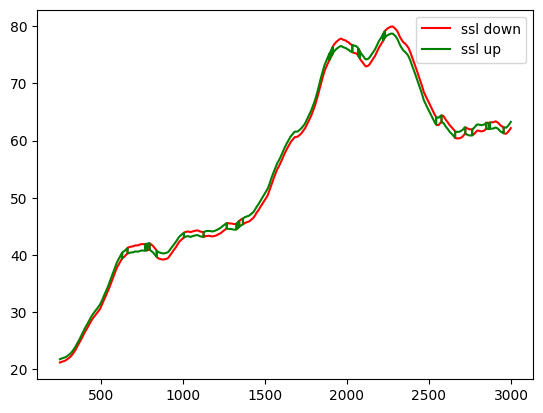

In [126]:
plt.plot(ssl_d,'r', label='ssl down')
plt.plot(ssl_u,'g', label='ssl up')
plt.legend()
plt.show()

In [6]:
from trade import pvt_with_divergence

In [20]:
def normalize_list(nums):
    min_val = np.min(nums)
    max_val = np.max(nums)
    return np.divide(np.subtract(nums, min_val), (max_val - min_val))

In [7]:

df = get_data(tv, "SET", "CPALL", 1000)
df = df.reset_index()
# pvtup, pvtdown, pvt_osc = pvt_with_divergence(df, 90, 95)
# pvtup = pvtup.dropna()
# pvtdown = pvtdown.dropna()
# pvtup.to_list()[-1]
# type(pvtdown)
rr = collect_mtfssl_pvtdiver(df,90,95)


sslup: 249    79.644
250    79.651
251    79.662
252    79.672
253    79.680
        ...  
995    62.029
996    62.064
997    62.101
998    62.141
999    62.177
Name: sslDown, Length: 751, dtype: float64
type sslup: <class 'pandas.core.series.Series'>
sslup -1: 62.177
ssldown -1: 63.262


In [17]:
x = pvt_osc[~np.isnan(pvt_osc)]

In [18]:
x

array([ 2.53245714e+04,  2.51906648e+04,  2.51624856e+04,  2.51239786e+04,
        2.50755989e+04,  2.47098091e+04,  2.42749438e+04,  2.37878487e+04,
        2.38842964e+04,  2.38534694e+04,  2.41813298e+04,  2.43407399e+04,
        2.43905559e+04,  2.46403202e+04,  2.47313702e+04,  2.59419023e+04,
        2.68739100e+04,  2.83924695e+04,  3.14741815e+04,  3.38547873e+04,
        3.55212005e+04,  3.71007711e+04,  3.88367813e+04,  4.22047079e+04,
        4.55430055e+04,  4.86560210e+04,  5.15471047e+04,  5.45157425e+04,
        5.72190209e+04,  5.97816067e+04,  6.26056026e+04,  6.53475564e+04,
        6.77824709e+04,  7.13014232e+04,  7.46386884e+04,  7.80476025e+04,
        8.14797769e+04,  8.46183641e+04,  8.77075620e+04,  9.08072139e+04,
        9.38801342e+04,  9.67799202e+04,  9.95125770e+04,  1.02375998e+05,
        1.05001061e+05,  1.06966028e+05,  1.08977312e+05,  1.10853514e+05,
        1.12532661e+05,  1.14773531e+05,  1.16762848e+05,  1.18571953e+05,
        1.20283944e+05,  

In [12]:
down.to_list()[-1]

0.004022814099329883

In [13]:
up.to_list()[-1]

0.005318296404505136

In [15]:
pvt_osc = pvt_osc.dropna()

In [17]:
pvt_osc.to_list()


[25324.571400932502,
 25190.66481675906,
 25162.48561236821,
 25123.978610721882,
 25075.59886138374,
 24709.809119890444,
 24274.943783096038,
 23787.848729218822,
 23884.296426639892,
 23853.469397174194,
 24181.329838111065,
 24340.739878166,
 24390.555878981482,
 24640.320200217888,
 24731.370215361938,
 25941.902254226618,
 26873.90995939728,
 28392.469542481005,
 31474.181469722185,
 33854.78727766266,
 35521.20051050885,
 37100.77105812216,
 38836.78132420499,
 42204.70789287146,
 45543.0054714852,
 48656.02101730229,
 51547.104699669406,
 54515.74253241997,
 57219.02085500723,
 59781.60674824752,
 62605.60261373874,
 65347.556405582465,
 67782.470940697,
 71301.423195438,
 74638.68840495963,
 78047.60251167882,
 81479.776855228,
 84618.36413882859,
 87707.56196569744,
 90807.21387979668,
 93880.1341788182,
 96779.92020044196,
 99512.57704294473,
 102375.99781536963,
 105001.0614911681,
 106966.02773801237,
 108977.31220257189,
 110853.5137343593,
 112532.66060826462,
 114773.53

In [195]:
def normalize_list(nums):
    nums = np.array(nums)
    min_val = np.min(nums)
    max_val = np.max(nums)
    return np.divide(np.subtract(nums, min_val), (max_val - min_val))

result = normalize_list(pvt_osc.to_list())

0.5318846055858459

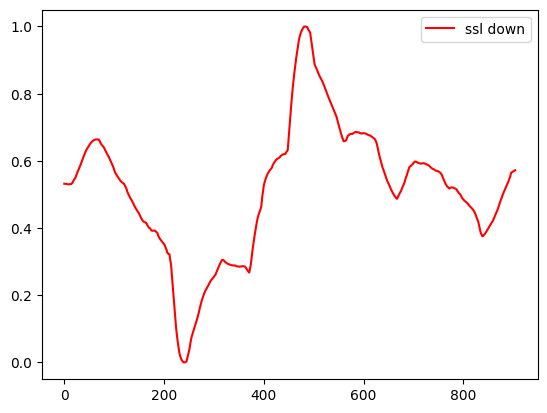

In [196]:
plt.plot(result,'r', label='ssl down')
plt.legend()
plt.show()